In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import sys

# Define the CSV file URL
csv_file_url = 'https://raw.githubusercontent.com/gilliansmac92/networkingletters/main/data/new-data/dated-topics-levenmelvillepapers.csv'

# Simple custom stopword list (in lowercase)
custom_stop_words = set([
    'king', 'service', 'parliament', 'friendship', 'duty', 'favor', 'honor',
    'loyalty', 'honesty', 'appointment', 'interest', 'friends', 'guilty',
    'church', 'privy', 'council', 'government', 'ministers', 'assembly'
])

def preprocess_keywords(text):
    """Lowercases and returns text for vectorization."""
    return text.lower()

def load_data(csv_url):
    df = pd.read_csv(csv_url)

    # Check for both cases of the column name and unify to 'TOPICS'
    if 'DATE' not in df.columns:
         raise ValueError("CSV must contain 'DATE' column.")

    # Check for 'TOPICS' or 'Topics' and rename to 'TOPICS' if 'Topics' exists
    if 'TOPICS' not in df.columns and 'Topics' not in df.columns:
         raise ValueError("CSV must contain 'TOPICS' or 'Topics' column.")
    elif 'Topics' in df.columns and 'TOPICS' not in df.columns:
        df.rename(columns={'Topics': 'TOPICS'}, inplace=True)


    df['date'] = pd.to_datetime(df['DATE'], errors='coerce')
    # Use 'TOPICS' (all caps) in the dropna subset to match the actual column name
    df = df.dropna(subset=['date', 'TOPICS'])

    df['year'] = df['date'].dt.year
    # Add half-year period column
    df['period'] = df['year'].astype(str) + '-H' + ((df['date'].dt.month > 6).astype(int) + 1).astype(str)

    df['topics'] = df['TOPICS'].astype(str).apply(preprocess_keywords)

    return df



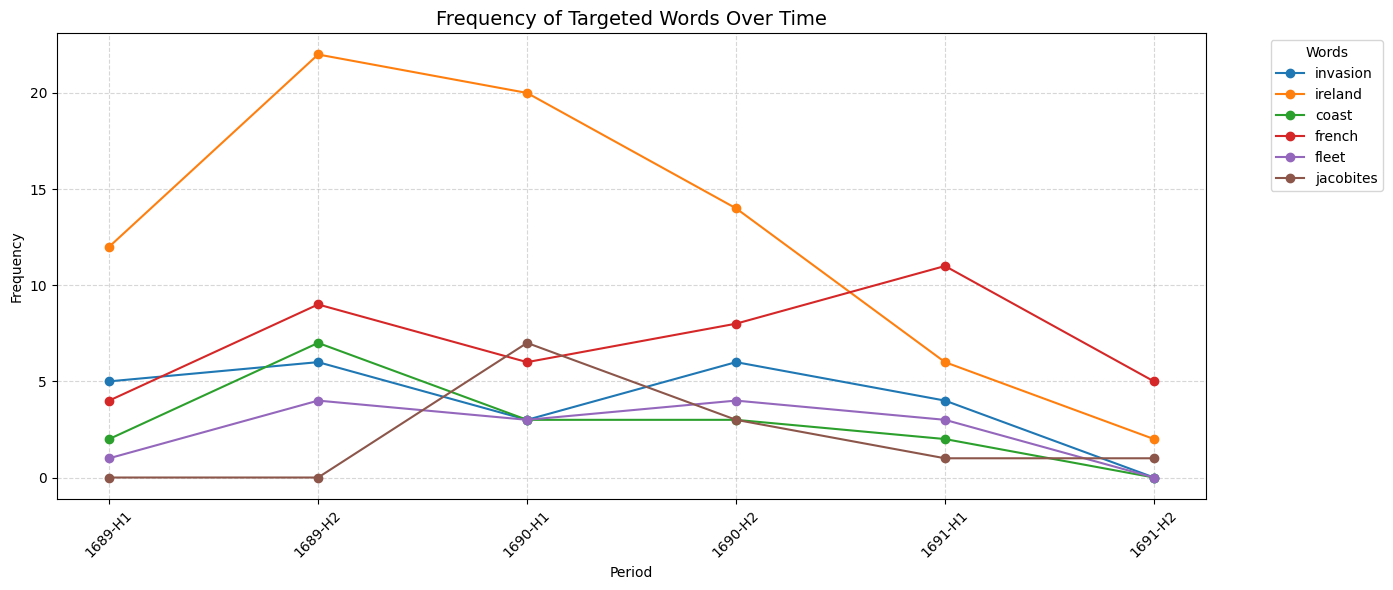

In [11]:
def plot_specific_words_trend(df, target_words):
    # Ensure consistent case
    target_words = [w.lower() for w in target_words]

    # Get unique sorted periods (e.g. '1689-H1', '1689-H2', ...)
    periods = sorted(df['period'].unique())

    word_freq_by_period = defaultdict(Counter)
    vectorizer = CountVectorizer(stop_words='english')

    for period in periods:
        texts = df[df['period'] == period]['topics']
        if texts.empty:
            continue
        X = vectorizer.fit_transform(texts)
        vocab = vectorizer.get_feature_names_out()
        counts = X.sum(axis=0).A1
        word_counts = dict(zip(vocab, counts))
        word_freq_by_period[period] = Counter(word_counts)

    # Plot
    import matplotlib.cm as cm
    plt.figure(figsize=(14, 6))
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i % 10) for i in range(len(target_words))]

    for i, word in enumerate(target_words):
        freqs = [word_freq_by_period.get(p, {}).get(word, 0) for p in periods]
        plt.plot(periods, freqs, marker='o', label=word, color=colors[i])

    plt.title("Frequency of Targeted Words Over Time", fontsize=14)
    plt.xlabel("Period")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Words", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Define target words outside the function
target_words = ['invasion', 'Ireland', 'coast', 'French', 'fleet', 'Jacobites']

# Load the data
df = load_data(csv_file_url)

# Call the function with the loaded data and target words
plot_specific_words_trend(df, target_words)
